## 552 Project

### 1. Original, with ReLU

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import tensorflow.keras.datasets.mnist as mnist
import numpy as np

ModuleNotFoundError: No module named 'tensorflow'

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#### Prepare the dataset

In [16]:
# Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Sampling of the training dataset: 600 images for each class
selected_indices_per_class = []
for class_idx in range(len(np.unique(y_train))):
    selected_indices = np.random.choice(np.where(y_train == class_idx)[0], size=600, replace=False)
    selected_indices_per_class.append(selected_indices)

selected_indices = np.concatenate(selected_indices_per_class)
np.random.shuffle(selected_indices)

x_train = x_train[selected_indices]
y_train = y_train[selected_indices]


# Normalization of X
# Find minimum and maximum values
min_val_train = np.min(x_train)
max_val_train = np.max(x_train)

min_val_test = np.min(x_test)
max_val_test = np.max(x_test)

# Linear transformation to normalize data to [0, 1]
normalized_x_train = (x_train - min_val_train) / (max_val_train - min_val_train)
normalized_x_test = (x_test - min_val_test) / (max_val_test - min_val_test)


In [17]:
# Define VGG11 network
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )


    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)   # Flatten it for the linear part
        x = self.fc_layers(x)     # Send it to the fully-connected layers
        return x


In [18]:
# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(normalized_x_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

In [19]:
x_test_tensor = torch.tensor(normalized_x_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [20]:
# Resize images to 32x32 using interpolate
x_train_resized = F.interpolate(x_train_tensor, size=(32, 32), mode='bilinear', align_corners=False)
# Define dataset and data loader
train_dataset = TensorDataset(x_train_resized, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [21]:
# Resize images to 32x32 using interpolate
x_test_resized = F.interpolate(x_test_tensor, size=(32, 32), mode='bilinear', align_corners=False)
# Define dataset and data loader
test_dataset = TensorDataset(x_test_resized, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [22]:
# Initialize VGG11 model
network = VGG11()

# Define optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)

In [23]:
# Train the model
accuracy_train = []
accuracy_test = []
train_losses = []
test_losses = []


In [78]:

def continue_training():
    network.train()      # configure the network for training
    correct_pred = 0
    epoch_loss = 0
    for data, target in train_loader:       # for each batch
        data = data.to(device)
        target = target.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = network(data)
        loss = criterion(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
        correct_pred += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs

    # Record the average loss for this epoch
    epoch_loss /= len(train_loader)     # for the current iteration
    train_losses.append(epoch_loss)

    # update the list of training accuracy values
    score = float(correct_pred/len(train_loader.dataset))
    accuracy_train.append(score)


def testing():
    correct_pred_test = 0
    epoch_loss_test = 0
    network.eval()
    with torch.no_grad():
        for data, target in test_loader:  # go through the test data once (in groups of 1000)
            data = data.to(device)
            target = target.to(device)
            output = network(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct_pred_test += pred.eq(target.data.view_as(pred)).sum()
            test_loss = criterion(output, target)
            epoch_loss_test += test_loss.item()
    
    # Record the average loss for this epoch
    epoch_loss_test /= len(test_loader)     # for the current iteration
    test_losses.append(epoch_loss_test)
    
    # update the list of testing accuracy values
    score_test = float(correct_pred_test/len(test_loader.dataset))
    accuracy_test.append(score_test)
    # print(f"score_test: {score_test}")


In [25]:
for i in range(20):
    print(f"{i+1}th training iteration")
    continue_training()
    testing()

1th training iteration
2th training iteration
3th training iteration
4th training iteration
5th training iteration
6th training iteration
7th training iteration
8th training iteration
9th training iteration
10th training iteration
11th training iteration
12th training iteration
13th training iteration
14th training iteration
15th training iteration
16th training iteration
17th training iteration
18th training iteration
19th training iteration
20th training iteration


In [26]:
accuracy_train_original = accuracy_train[:]
accuracy_test_original = accuracy_test[:]
train_losses_original = train_losses[:]
test_losses_original = test_losses[:]

In [61]:
print(len(accuracy_train_original))

20


#### Explanation on why resizing the images from 28*28 to 32*32:

To fit the minimum requirement of maxpooling: 2^5 =32

The VGG11 model has 5 maxpooling layers, each reduces the dimensions of the input by a factor of 2, and starting with a 32x32 image allows for 5 max-pooling operations to be applied while still maintaining a non-zero dimension.

#### Plot

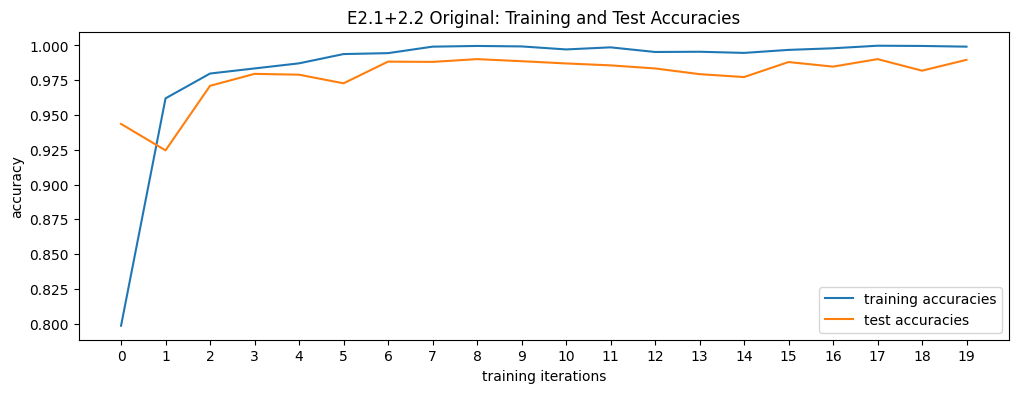

In [27]:
plt.figure(figsize=(12,4))
plt.plot(accuracy_train_original, label='training accuracies')
plt.plot(accuracy_test_original, label='test accuracies')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.title('Original: Training and Test Accuracies')
plt.xticks(np.arange(0, len(accuracy_train_original), 1))
plt.show()

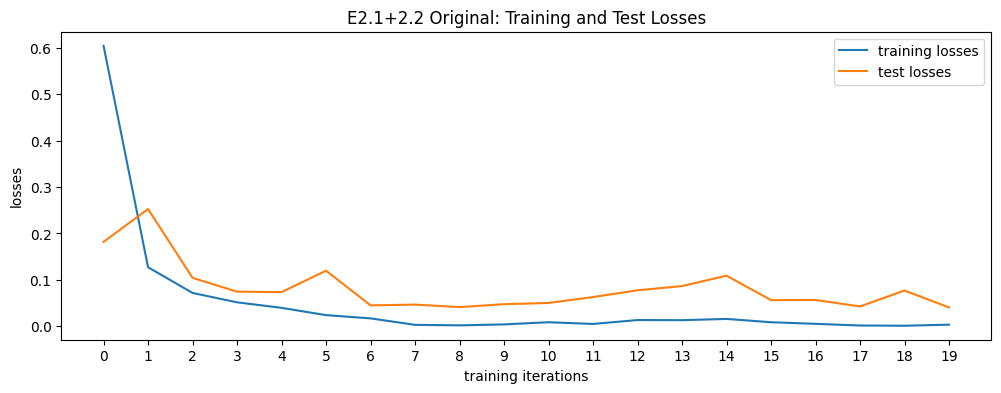

In [28]:
plt.figure(figsize=(12,4))
plt.plot(train_losses_original, label='training losses')
plt.plot(test_losses_original, label='test losses')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('losses')
plt.title('E2.1+2.2 Original: Training and Test Losses')
plt.xticks(np.arange(0, len(accuracy_train_original), 1))
plt.show()

#### 2. Replace ReLU with Sigmoid

In [29]:
# Define VGG11 network
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.Sigmoid(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(512, 4096),
            nn.Sigmoid(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.Sigmoid(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )


    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)   # Flatten it for the linear part
        x = self.fc_layers(x)     # Send it to the fully-connected layers
        return x


In [30]:
# Initialize VGG11 model
network = VGG11()

# Define optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)

In [31]:
# Train the model
accuracy_train = []
accuracy_test = []
train_losses = []
test_losses = []

In [32]:

def continue_training():
    network.train()      # configure the network for training
    correct_pred = 0
    epoch_loss = 0
    for data, target in train_loader:       # for each batch
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = network(data)
        loss = criterion(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
        correct_pred += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs

    # Record the average loss for this epoch
    epoch_loss /= len(train_loader)     # for the current iteration
    train_losses.append(epoch_loss)

    # update the list of training accuracy values
    score = float(correct_pred/len(train_loader.dataset))
    accuracy_train.append(score)


def testing():
    correct_pred_test = 0
    epoch_loss_test = 0
    network.eval()
    with torch.no_grad():
        for data, target in test_loader:  # go through the test data once (in groups of 1000)
            output = network(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct_pred_test += pred.eq(target.data.view_as(pred)).sum()
            test_loss = criterion(output, target)
            epoch_loss_test += test_loss.item()
    
    # Record the average loss for this epoch
    epoch_loss_test /= len(test_loader)     # for the current iteration
    test_losses.append(epoch_loss_test)
    
    # update the list of testing accuracy values
    score_test = float(correct_pred_test/len(test_loader.dataset))
    accuracy_test.append(score_test)
    # print(f"score_test: {score_test}")


In [33]:
for i in range(20):
    print(f"{i+1}th training iteration")
    continue_training()
    testing()

1th training iteration
2th training iteration
3th training iteration
4th training iteration
5th training iteration
6th training iteration
7th training iteration
8th training iteration
9th training iteration
10th training iteration
11th training iteration
12th training iteration
13th training iteration
14th training iteration
15th training iteration
16th training iteration
17th training iteration
18th training iteration
19th training iteration
20th training iteration


In [34]:
accuracy_train_sigmoid = accuracy_train[:]
accuracy_test_sigmoid = accuracy_test[:]
train_losses_sigmoid = train_losses[:]
test_losses_sigmoid = test_losses[:]

In [63]:
print(len(accuracy_test_sigmoid))

20


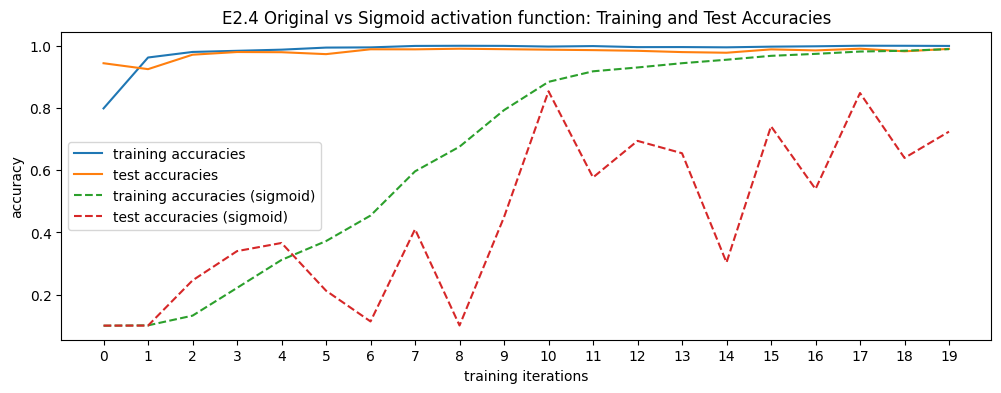

In [35]:
plt.figure(figsize=(12,4))
plt.plot(accuracy_train_original, label='training accuracies')
plt.plot(accuracy_test_original, label='test accuracies')
plt.plot(accuracy_train_sigmoid, label='training accuracies (sigmoid)', linestyle='--')
plt.plot(accuracy_test_sigmoid, label='test accuracies (sigmoid)', linestyle='--')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.title('Test 2: Original vs Sigmoid activation function: Training and Test Accuracies')
plt.xticks(np.arange(0, len(accuracy_train), 1))
plt.show()

Explanation:

For this network, the ReLU activation functions perform better than the sigmoid function.

Reason being:
1) The VGG network doesn't require the input to be between 0 and 1, thus does not take the advantage of sigmoid.
2) When values are very big or very small, the gradient of sigmoid is close to 0. Thus let the earlier layers hard to be optimized.

While ReLU provides a good solution to the vanishing gradient problem. When the value is positive, the gradient is 1 and lead to faster and more efficient backpropagation.

#### 3. Replace ReLU with ADA

In [79]:
class CustomActivation(nn.Module):
    def __init__(self, name, alpha=0.5):
        super(CustomActivation, self).__init__()
        self.name = name
        self.alpha = alpha

    def forward(self, x):
        if self.name == "ADA":
            return torch.maximum(x, torch.tensor(0.)) * torch.exp(-x * self.alpha)
        elif 

In [80]:
# Define VGG11 network
class VGG11(nn.Module):
    def __init__(self, activation_func):
        super(VGG11, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            activation_func,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            CustomActivation(name = activation_name),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            CustomActivation(name = activation_name),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            CustomActivation(name = activation_name),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            CustomActivation(name = activation_name),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            CustomActivation(name = activation_name),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            CustomActivation(name = activation_name),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            CustomActivation(name = activation_name),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(512, 4096),
            CustomActivation(name = activation_name),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            CustomActivation(name = activation_name),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [81]:
device = 'cpu'
# Check if MPS is supported and available
if torch.backends.mps.is_available():
    print("MPS is available on this device.")
    device = torch.device("mps")  # Use MPS device
else:
    print("MPS not available, using CPU instead.")
    device = torch.device("cpu")  # Fallback to CPU

MPS is available on this device.


In [82]:
# Initialize VGG11 model
act_fun = CustomActivation(name="ADA")
network = VGG11(act_fun)
network.to(device)

act_fun = CustomActivation(name="BDA")

# Define optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)

In [83]:
# Train the model
accuracy_train = []
accuracy_test = []
train_losses = []
test_losses = []

In [84]:
for i in range(20):
    print(f"{i+1}th training iteration")
    continue_training()
    testing()

1th training iteration
2th training iteration
3th training iteration
4th training iteration
5th training iteration
6th training iteration
7th training iteration
8th training iteration
9th training iteration
10th training iteration
11th training iteration
12th training iteration
13th training iteration
14th training iteration
15th training iteration
16th training iteration
17th training iteration
18th training iteration
19th training iteration
20th training iteration


In [85]:
print(len(accuracy_train))

20


In [86]:
print(accuracy_test)

[0.4986000061035156, 0.7906000018119812, 0.9258999824523926, 0.9527999758720398, 0.9391000270843506, 0.9390000104904175, 0.9556000232696533, 0.9638000130653381, 0.9573000073432922, 0.9729999899864197, 0.9157999753952026, 0.9679999947547913, 0.9736999869346619, 0.9747999906539917, 0.9746999740600586, 0.9603999853134155, 0.96670001745224, 0.9739000201225281, 0.9688000082969666, 0.9819999933242798]


In [87]:
accuracy_train_ada = accuracy_train[:]
accuracy_test_ada = accuracy_test[:]
train_losses_ada = train_losses[:]
test_losses_ada = test_losses[:]

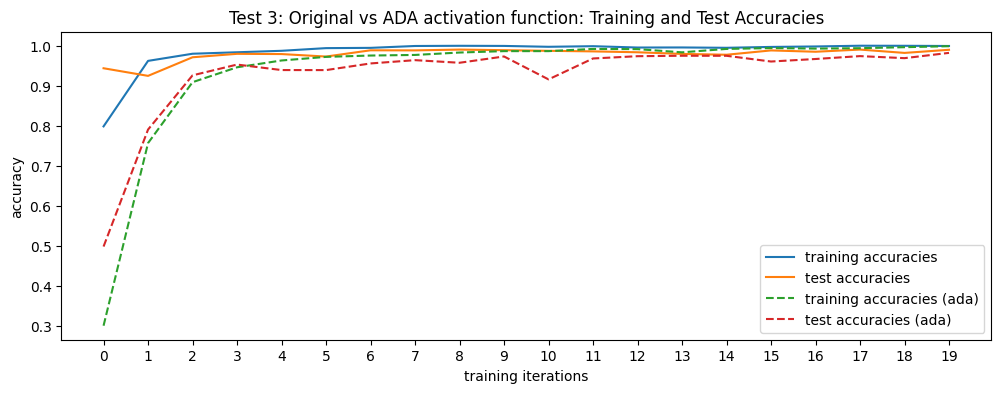

In [88]:
plt.figure(figsize=(12,4))
plt.plot(accuracy_train_original, label='training accuracies')
plt.plot(accuracy_test_original, label='test accuracies')
plt.plot(accuracy_train_ada, label='training accuracies (ada)', linestyle='--')
plt.plot(accuracy_test_ada, label='test accuracies (ada)', linestyle='--')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.title('Test 3: Original vs ADA activation function: Training and Test Accuracies')
plt.xticks(np.arange(0, len(accuracy_train), 1))
plt.show()

#### 4. Replace ReLU with Leaky ADA

In [95]:
class CustomActivation(nn.Module):
    def __init__(self, name="Leaky_ADA", alpha=0.5, leak=0.01):
        super(CustomActivation, self).__init__()
        self.name = name
        self.alpha = alpha
        self.leak = leak

    def forward(self, x):
        return self.leak * torch.min(x, torch.tensor(0.0)) + torch.max(x, torch.tensor(0.0)) * torch.exp(-x * self.alpha)

In [96]:
device = 'cpu'
# Check if MPS is supported and available
if torch.backends.mps.is_available():
    print("MPS is available on this device.")
    device = torch.device("mps")  # Use MPS device
else:
    print("MPS not available, using CPU instead.")
    device = torch.device("cpu")  # Fallback to CPU

MPS is available on this device.


In [97]:
# Initialize VGG11 model
network = VGG11()
network.to(device)

# Define optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)

In [101]:
# Train the model
accuracy_train = []
accuracy_test = []
train_losses = []
test_losses = []

In [102]:
for i in range(20):
    print(f"{i+1}th training iteration")
    continue_training()
    testing()

1th training iteration
2th training iteration
3th training iteration
4th training iteration
5th training iteration
6th training iteration
7th training iteration
8th training iteration
9th training iteration
10th training iteration
11th training iteration
12th training iteration
13th training iteration
14th training iteration
15th training iteration
16th training iteration
17th training iteration
18th training iteration
19th training iteration
20th training iteration


In [103]:
accuracy_train_leaky_ada = accuracy_train[:]
accuracy_test_leaky_ada = accuracy_test[:]
train_losses_leaky_ada = train_losses[:]
test_losses_leaky_ada = test_losses[:]

In [106]:
print(accuracy_train_leaky_ada)

[0.9988333582878113, 0.999666690826416, 0.999833345413208, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999833345413208, 0.9994999766349792, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [107]:
print(accuracy_test_leaky_ada)

[0.9819999933242798, 0.9843000173568726, 0.9837999939918518, 0.9853000044822693, 0.9861000180244446, 0.9861000180244446, 0.9861999750137329, 0.98580002784729, 0.9847000241279602, 0.9833999872207642, 0.9857000112533569, 0.9850999712944031, 0.9855999946594238, 0.9854999780654907, 0.9855999946594238, 0.9858999848365784, 0.9858999848365784, 0.9855999946594238, 0.9853000044822693, 0.9866999983787537]


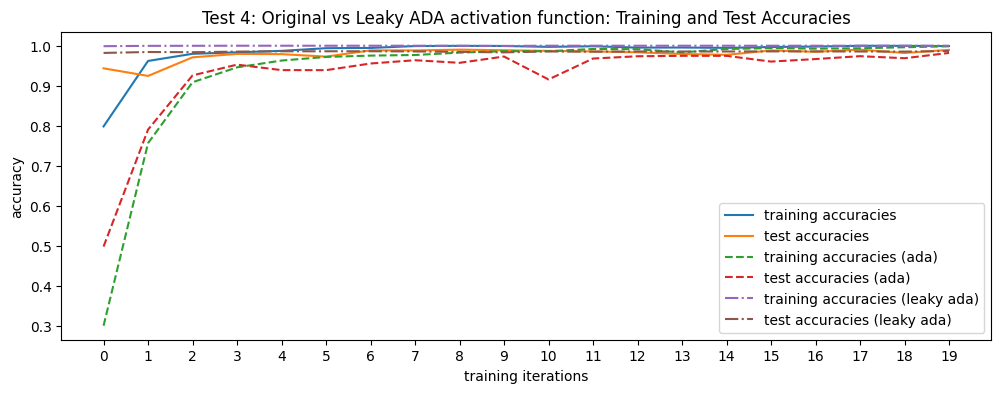

In [120]:
plt.figure(figsize=(12,4))
plt.plot(accuracy_train_original, label='training accuracies')
plt.plot(accuracy_test_original, label='test accuracies')
plt.plot(accuracy_train_ada, label='training accuracies (ada)', linestyle='--')
plt.plot(accuracy_test_ada, label='test accuracies (ada)', linestyle='--')
plt.plot(accuracy_train_leaky_ada, label='training accuracies (leaky ada)', linestyle='-.')
plt.plot(accuracy_test_leaky_ada, label='test accuracies (leaky ada)', linestyle='-.')

plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.title('Test 4: Original vs Leaky ADA activation function: Training and Test Accuracies')
plt.xticks(np.arange(0, len(accuracy_train), 1))
plt.show()

### 5. With Swish

In [109]:
class CustomActivation(nn.Module):
    def __init__(self, name="Swish", alpha=1.0):
        super(CustomActivation, self).__init__()
        self.name = name
        self.alpha = alpha

    def forward(self, x):
        return x * torch.sigmoid(self.alpha * x)

In [110]:
device = 'cpu'
# Check if MPS is supported and available
if torch.backends.mps.is_available():
    print("MPS is available on this device.")
    device = torch.device("mps")  # Use MPS device
else:
    print("MPS not available, using CPU instead.")
    device = torch.device("cpu")  # Fallback to CPU

MPS is available on this device.


In [111]:
# Initialize VGG11 model
network = VGG11()
network.to(device)

# Define optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)

In [112]:
# Train the model
accuracy_train = []
accuracy_test = []
train_losses = []
test_losses = []

In [113]:
for i in range(20):
    print(f"{i+1}th training iteration")
    continue_training()
    testing()

1th training iteration
2th training iteration
3th training iteration
4th training iteration
5th training iteration
6th training iteration
7th training iteration
8th training iteration
9th training iteration
10th training iteration
11th training iteration
12th training iteration
13th training iteration
14th training iteration
15th training iteration
16th training iteration
17th training iteration
18th training iteration
19th training iteration
20th training iteration


In [114]:
accuracy_train_swish = accuracy_train[:]
accuracy_test_swish = accuracy_test[:]
train_losses_swish = train_losses[:]
test_losses_swish = test_losses[:]

In [115]:
print(accuracy_train_swish)

[0.8246666789054871, 0.9731666445732117, 0.9848333597183228, 0.9923333525657654, 0.9955000281333923, 0.9929999709129333, 0.9961666464805603, 0.9986666440963745, 0.9990000128746033, 0.999833345413208, 0.999833345413208, 0.9994999766349792, 0.9994999766349792, 0.999833345413208, 0.9991666674613953, 0.999666690826416, 0.999833345413208, 1.0, 1.0, 1.0]


In [116]:
print(accuracy_test_swish)

[0.9265000224113464, 0.9749000072479248, 0.9646000266075134, 0.9715999960899353, 0.9714999794960022, 0.972000002861023, 0.9842000007629395, 0.9871000051498413, 0.9865000247955322, 0.9890999794006348, 0.9876999855041504, 0.9728000164031982, 0.9889000058174133, 0.9886999726295471, 0.9886000156402588, 0.9866999983787537, 0.9886999726295471, 0.9887999892234802, 0.9894000291824341, 0.9896000027656555]


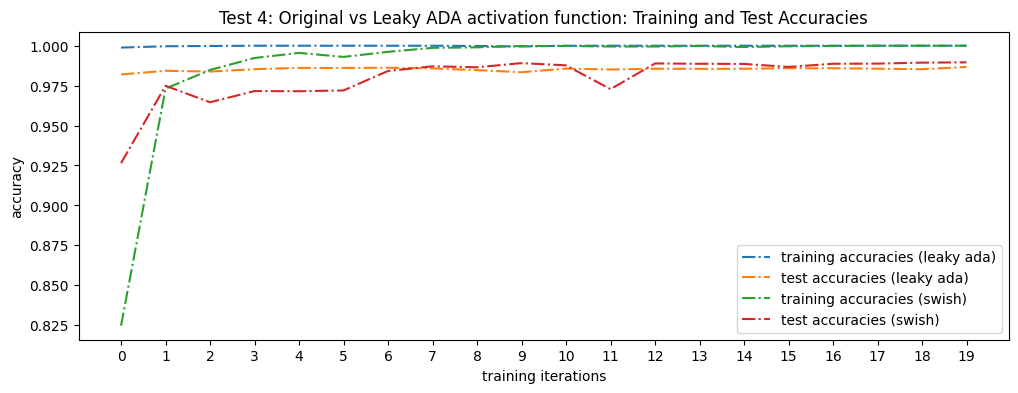

In [121]:
plt.figure(figsize=(12,4))
# plt.plot(accuracy_train_original, label='training accuracies')
# plt.plot(accuracy_test_original, label='test accuracies')
# plt.plot(accuracy_train_ada, label='training accuracies (ada)', linestyle='--')
# plt.plot(accuracy_test_ada, label='test accuracies (ada)', linestyle='--')
plt.plot(accuracy_train_leaky_ada, label='training accuracies (leaky ada)', linestyle='-.')
plt.plot(accuracy_test_leaky_ada, label='test accuracies (leaky ada)', linestyle='-.')
plt.plot(accuracy_train_swish, label='training accuracies (swish)', linestyle='-.')
plt.plot(accuracy_test_swish, label='test accuracies (swish)', linestyle='-.')

plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.title('Test 4: Original vs Leaky ADA activation function: Training and Test Accuracies')
plt.xticks(np.arange(0, len(accuracy_train), 1))
plt.show()

In [ ]:
# from torchsummary import summary
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# network.to(device)
# summary(network, (1, 32, 32))

## Reduce the number of neurons

In [137]:
class CustomActivation(nn.Module):
    def __init__(self, name="Leaky_ADA", alpha=0.5, leak=0.01):
        super(CustomActivation, self).__init__()
        self.name = name
        self.alpha = alpha
        self.leak = leak

    def forward(self, x):
        return self.leak * torch.min(x, torch.tensor(0.0)) + torch.max(x, torch.tensor(0.0)) * torch.exp(-x * self.alpha)

In [138]:
# class LeNet5(nn.Module):
#     def __init__(self, num_classes=10):
#         super(LeNet5, self).__init__()
#         self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
#         self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
#         self.fc1 = nn.Linear(16*5*5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, num_classes)
#         self.activation = CustomActivation()  # 
# 
#     def forward(self, x):
#         x = nn.functional.avg_pool2d(self.activation(self.conv1(x)), kernel_size=2, stride=2)
#         x = nn.functional.avg_pool2d(self.activation(self.conv2(x)), kernel_size=2, stride=2)
#         x = torch.flatten(x, 1)
#         x = self.activation(self.fc1(x))
#         x = self.activation(self.fc2(x))
#         x = self.fc3(x)
#         return x

In [139]:
device = 'cpu'
# Check if MPS is supported and available
if torch.backends.mps.is_available():
    print("MPS is available on this device.")
    device = torch.device("mps")  # Use MPS device
else:
    print("MPS not available, using CPU instead.")
    device = torch.device("cpu")  # Fallback to CPU

MPS is available on this device.


In [140]:
# Initialize LeNet5 model
network = LeNet5()
network.to(device)

# Define optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)

In [141]:
# Train the model
accuracy_train = []
accuracy_test = []
train_losses = []
test_losses = []

In [142]:
for i in range(20):
    print(f"{i+1}th training iteration")
    continue_training()
    testing()

1th training iteration
2th training iteration
3th training iteration
4th training iteration
5th training iteration
6th training iteration
7th training iteration
8th training iteration
9th training iteration
10th training iteration
11th training iteration
12th training iteration
13th training iteration
14th training iteration
15th training iteration
16th training iteration
17th training iteration
18th training iteration
19th training iteration
20th training iteration


In [143]:
accuracy_train_lenet = accuracy_train[:]
accuracy_test_lenet = accuracy_test[:]
train_losses_lenet = train_losses[:]
test_losses_lenet = test_losses[:]

In [144]:
print(accuracy_train_lenet)
print(accuracy_test_lenet)

[0.09700000286102295, 0.1431666612625122, 0.3491666615009308, 0.4178333282470703, 0.4868333339691162, 0.6445000171661377, 0.7606666684150696, 0.8199999928474426, 0.8508333563804626, 0.8736666440963745, 0.8893333077430725, 0.9023333191871643, 0.9123333096504211, 0.9153333306312561, 0.9241666793823242, 0.9308333396911621, 0.9325000047683716, 0.9415000081062317, 0.9458333253860474, 0.9496666789054871]
[0.10909999907016754, 0.3125, 0.4650999903678894, 0.44760000705718994, 0.5874000191688538, 0.7455999851226807, 0.8119000196456909, 0.8463000059127808, 0.8622000217437744, 0.8881999850273132, 0.9000999927520752, 0.9035000205039978, 0.9139999747276306, 0.9203000068664551, 0.917900025844574, 0.9301999807357788, 0.9361000061035156, 0.9395999908447266, 0.9434000253677368, 0.944100022315979]


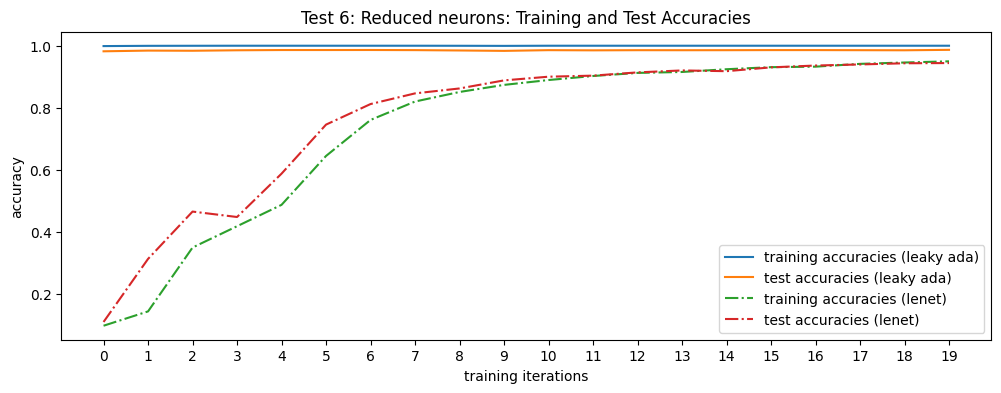

In [146]:
plt.figure(figsize=(12,4))
# plt.plot(accuracy_train_original, label='training accuracies')
# plt.plot(accuracy_test_original, label='test accuracies')
# plt.plot(accuracy_train_ada, label='training accuracies (ada)', linestyle='--')
# plt.plot(accuracy_test_ada, label='test accuracies (ada)', linestyle='--')
plt.plot(accuracy_train_leaky_ada, label='training accuracies (leaky ada)')
plt.plot(accuracy_test_leaky_ada, label='test accuracies (leaky ada)')
plt.plot(accuracy_train_lenet, label='training accuracies (lenet)', linestyle='-.')
plt.plot(accuracy_test_lenet, label='test accuracies (lenet)', linestyle='-.')

plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.title('Test 6: Reduced neurons: Training and Test Accuracies')
plt.xticks(np.arange(0, len(accuracy_train), 1))
plt.show()